## LOAD AND ANALYZE DATASET


In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore

In [67]:
# Load datasets
emotion_df = pd.read_csv("data/emotions_dataset.csv")
hate_df = pd.read_csv("data/hate_speech_dataset.csv")
violence_df = pd.read_csv("data/violence_dataset/violence_dataset.csv")

# Function to display dataset info
def display_dataset_info(name, df):
    print(f"\n{'='*20} {name.upper()} DATASET {'='*20}")
    print(f"\n👉 Shape: {df.shape}")
    print(f"\n👉 Columns: {df.columns.tolist()}")
    print(f"\n👉 Head:\n{df.head()}")

# Display info for each dataset
display_dataset_info("Emotion", emotion_df)
display_dataset_info("Violence", violence_df)
display_dataset_info("Hate Speech", hate_df)



==================== EMOTION DATASET ====================

👉 Shape: (416809, 3)

👉 Columns: ['Unnamed: 0', 'text', 'label']

👉 Head:
   Unnamed: 0                                               text  label
0           0      i just feel really helpless and heavy hearted      4
1           1  ive enjoyed being able to slouch about relax a...      0
2           2  i gave up my internship with the dmrg and am f...      4
3           3                         i dont know i feel so lost      0
4           4  i am a kindergarten teacher and i am thoroughl...      4

==================== VIOLENCE DATASET ====================

👉 Shape: (39650, 3)

👉 Columns: ['Tweet_ID', 'tweet', 'type']

👉 Head:
      Tweet_ID                                              tweet  \
0  ID_0022DWKP  Had a dream i got raped last night. By a guy i...   
1  ID_00395QYM  he thought the word raped means sex and told m...   
2  ID_003EOSSF  She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...   
3  ID_004BBHOD  I was sexu

## DATA PREPROCESSING

In [68]:
# Dropping unwanted columns

emotion_df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
violence_df.drop(columns=['Tweet_ID'], inplace=True, errors='ignore')
hate_df = hate_df[['tweet', 'class']] # Didnt use drop as classes to drop were many.

In [69]:
def display_dataset_info(name, df):
    print(f"\n{'='*20} {name.upper()} DATASET {'='*20}")
    print(f"\n👉 Shape: {df.shape}")
    print(f"\n👉 Columns: {df.columns.tolist()}")
    print(f"\n👉 Head:\n{df.head()}")

# Display info for each dataset
display_dataset_info("Emotion", emotion_df)
display_dataset_info("Violence", violence_df)
display_dataset_info("Hate Speech", hate_df)


==================== EMOTION DATASET ====================

👉 Shape: (416809, 2)

👉 Columns: ['text', 'label']

👉 Head:
                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4

==================== VIOLENCE DATASET ====================

👉 Shape: (39650, 2)

👉 Columns: ['tweet', 'type']

👉 Head:
                                               tweet             type
0  Had a dream i got raped last night. By a guy i...  sexual_violence
1  he thought the word raped means sex and told m...  sexual_violence
2  She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...  sexual_violence
3  I was sexually abused for 3 years at age 4 to ...  sexual_violence
4  Chessy Prout can do better by telling the trut.

We notice that column names of labels of all datasets are not consistent..

In [70]:
#Renaming the columns for consistency
#emotion_df already has 'text' and 'label' columns
hate_df.rename(columns={'tweet':'text', 'class':'label'}, inplace=True)  
violence_df.rename(columns={'tweet': 'text', 'type':'label'}, inplace=True)

In [71]:
print(emotion_df.columns)
print(violence_df.columns)
print(hate_df.columns)

Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')


Checking for null values

In [72]:
emotion_df.isna().sum() , violence_df.isna().sum(), hate_df.isna().sum()

(text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64)

Great!! No null values!!

In [73]:
emotion_df.shape, violence_df.shape, hate_df.shape

((416809, 2), (39650, 2), (24783, 2))

We can see that #rows are highly inconsistent here,

So we can select 20k rows from each dataset and build 3 new datasets.

This rows should be distributed equally among all classes.

In [74]:
emotion_df.label.value_counts(), violence_df.label.value_counts(), hate_df.label.value_counts()

(label
 1    141067
 0    121187
 3     57317
 4     47712
 2     34554
 5     14972
 Name: count, dtype: int64,
 label
 sexual_violence                 32648
 Physical_violence                5946
 emotional_violence                651
 economic_violence                 217
 Harmful_Traditional_practice      188
 Name: count, dtype: int64,
 label
 1    19190
 2     4163
 0     1430
 Name: count, dtype: int64)

1. Firstly for Emotions dataset


In [75]:
e_df = pd.DataFrame()

for i in emotion_df.label.unique():
    subset = emotion_df[emotion_df.label == i].sample(n=2000, random_state=42) #extracting random 2k rows from each class.
    e_df = pd.concat([e_df, subset], ignore_index=True)

In [76]:
e_df.shape

(12000, 2)

In [77]:
emotion_df = e_df.copy()
print(emotion_df.label.value_counts())

label
4    2000
0    2000
2    2000
1    2000
5    2000
3    2000
Name: count, dtype: int64


2. Secondly for Violence dataset

In [78]:
violence_df.label.value_counts()

label
sexual_violence                 32648
Physical_violence                5946
emotional_violence                651
economic_violence                 217
Harmful_Traditional_practice      188
Name: count, dtype: int64

Since there is a huge imbalance we need to balance it accordingly.

Since emotional_violence, economic_violence, and political_violence are low frequency classes, 

we will use all the data for these classes.

We will also keep all of physical_violence, 

and for sexual_violence we will keep 4998 random rows to get the total row count to 12000.

In [79]:
#creating new column for 'sexual_violence' to balance the dataset, and appending it to the existing violence_df
sexual_violence = violence_df[violence_df.label == 'sexual_violence'].sample(n=4998, random_state=42)
violence_df = pd.concat([violence_df[violence_df.label != 'sexual_violence'], sexual_violence], ignore_index=True)
print(violence_df.label.value_counts())

label
Physical_violence               5946
sexual_violence                 4998
emotional_violence               651
economic_violence                217
Harmful_Traditional_practice     188
Name: count, dtype: int64


In [80]:
violence_df.shape

(12000, 2)

3. Lastly for Hate dataframe

In [81]:
hate_df.label.value_counts()

label
1    19190
2     4163
0     1430
Name: count, dtype: int64

Here also we will take all of 2,0 classes and 

for 1st class we use 6407 rows to complete the dataset size of 12k

In [82]:
#creating new column for 1 to balance the dataset, and appending it to the existing hate_df

offensive_speech = hate_df[hate_df.label == 1].sample(n=6407, random_state=42)
hate_df = pd.concat([hate_df[hate_df.label !=1], offensive_speech], ignore_index=True)
print(hate_df.label.value_counts())

label
1    6407
2    4163
0    1430
Name: count, dtype: int64


In [83]:
emotion_df.shape, violence_df.shape, hate_df.shape

((12000, 2), (12000, 2), (12000, 2))

Now all our new df shapes are consistent

Since we have randomly selected our dataset, their indices are random as well.

So we need to reset the indices.

In [84]:
#Reset index for all datasets
emotion_df.reset_index(drop=True, inplace=True)
violence_df.reset_index(drop=True, inplace=True)
hate_df.reset_index(drop=True, inplace=True)

In [85]:
# Function to display dataset info
def display_dataset_info(name, df):
    print(f"\n{'='*20} {name.upper()} DATASET {'='*20}")
    # print(f"\n👉 Shape: {df.shape}")
    # print(f"\n👉 Columns: {df.columns.tolist()}")
    print(f"\n👉 Head:\n{df.head()}")

# Display info for each dataset
display_dataset_info("Emotion", emotion_df)
display_dataset_info("Violence", violence_df)
display_dataset_info("Hate Speech", hate_df)


==================== EMOTION DATASET ====================

👉 Head:
                                                text  label
0  i feel that it creates a suspicious environmen...      4
1               i feel reluctant asking for anything      4
2  i am afraid to really show what i feel because...      4
3  i think he feels a little helpless in all this...      4
4                          i certainly feel tortured      4

==================== VIOLENCE DATASET ====================

👉 Head:
                                                text              label
0  My Husband Beats Me Frequently, Wife Tells Cou...  Physical_violence
1  Best thing for me to do, is remain silent when...  Physical_violence
2  My husband will never beat me, Bambam denies r...  Physical_violence
3  theyre like, i just wanna be a baby maker with...  Physical_violence
4  I was in England for a week, the longest I’ve ...  Physical_violence

==================== HATE SPEECH DATASET ====================

👉 Head:

Now the indices are consistent as well..

## LABEL ENCODING

We dont need encoding for Emotion and Hate Speech Datasets, We only need to do it for Violence dataset

In [86]:
label_encoder = LabelEncoder()
violence_df['label'] = label_encoder.fit_transform(violence_df['label'])

In [89]:
violence_df['label'].value_counts()

label
1    5946
4    4998
3     651
2     217
0     188
Name: count, dtype: int64

Now labels in Violence Dataset have been encoded.

## STOP WORDS REMOVAL

In [92]:
# Firstly downloading stopwords and punctuations
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shivangsingh/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shivangsingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [96]:
#loading stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)
print(len(stop_words))

{'t', 'own', 'than', 'he', 'yours', 'there', 'on', 've', "we'd", 'nor', 'a', "you'll", 'isn', 'be', 'wasn', 'again', 'above', 'very', "i've", 'off', "she's", "he's", 'because', "mustn't", 'themselves', 'with', 'if', 'not', 'once', "wouldn't", 'at', 'were', 'd', "i'll", 'or', 'needn', 'have', 'both', 'weren', 'hers', 'down', "haven't", 'shan', 'as', 'had', 'into', 'been', 'hasn', "isn't", "i'm", 'having', "you're", 'further', 'between', 'should', "needn't", 'our', 'but', 'your', 'during', 'does', 'himself', "we've", "we're", 'too', 'shouldn', 'can', "should've", 'didn', 'did', 'ourselves', "they'll", "couldn't", 'herself', 'my', 'in', 'few', 'by', 'me', 'mustn', 'through', 'i', 'wouldn', 'y', "you've", "they'd", 'below', 'now', 'them', 'from', 'it', "hadn't", 'when', 'myself', 'ain', 'are', 'each', 'o', 'couldn', 'of', 'and', 'you', 'him', 'then', 'yourself', 'other', 'any', "she'll", 'such', 'the', 'whom', 'about', 'for', 'ma', 'these', 'to', "didn't", 'doesn', 'she', "we'll", 'what', 

So there are 198 stopwords currently present in the english language

In [ ]:
#Stopwords Removal Function
def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.isalpha()]
    return ' '.join(filtered_tokens)

# Lets apply the stopwords removal function to each dataset
emotion_df['text'] = emotion_df['text'].apply(remove_stopwords)
violence_df['text'] = violence_df['text'].apply(remove_stopwords)
hate_df['text'] = hate_df['text'].apply(remove_stopwords)

<WordListCorpusReader in '/Users/shivangsingh/nltk_data/corpora/stopwords'>

In [97]:
emotion_df.head(), violence_df.head(), hate_df.head()

(                                                text  label
 0  i feel that it creates a suspicious environmen...      4
 1               i feel reluctant asking for anything      4
 2  i am afraid to really show what i feel because...      4
 3  i think he feels a little helpless in all this...      4
 4                          i certainly feel tortured      4,
                                                 text  label
 0  My Husband Beats Me Frequently, Wife Tells Cou...      1
 1  Best thing for me to do, is remain silent when...      1
 2  My husband will never beat me, Bambam denies r...      1
 3  theyre like, i just wanna be a baby maker with...      1
 4  I was in England for a week, the longest I’ve ...      1,
                                                 text  label
 0  !!! RT @mayasolovely: As a woman you shouldn't...      2
 1    " momma said no pussy cats inside my doghouse "      2
 2  "@Addicted2Guys: -SimplyAddictedToGuys http://...      2
 3  "@AllAboutManFeet:

## TOKENIZATION AND PADDING

In [ ]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(pd.concat([emotion_df['text'],  violence_df['text'], hate_df['text']]))
# Convert texts to sequences(of numbers. eg i am happy ----> [1, 2, 3, 4] if the words are mapped to these numbers)
emotion_sequences = tokenizer.texts_to_sequences(emotion_df['text'])
violence_sequences = tokenizer.texts_to_sequences(violence_df['text'])
hate_sequences = tokenizer.texts_to_sequences(hate_df['text'])

In [105]:
emotion_df['text'].iloc[2], emotion_sequences[2]

('i am afraid to really show what i feel because im terrified of having it thrown back in my face',
 [1,
  53,
  517,
  3,
  83,
  317,
  50,
  1,
  12,
  46,
  56,
  980,
  10,
  217,
  15,
  2304,
  119,
  11,
  7,
  302])

In [103]:
## Now we will add padding to the sequences to make them of equal length
max_length = 50  # Define the maximum length of sequences
emotion_padded = pad_sequences(emotion_sequences, maxlen=max_length, padding='post')
violence_padded = pad_sequences(violence_sequences, maxlen=max_length, padding='post')
hate_padded = pad_sequences(hate_sequences, maxlen=max_length, padding='post')

In [104]:
emotion_df['text'].iloc[2], emotion_padded[2]

('i am afraid to really show what i feel because im terrified of having it thrown back in my face',
 array([   1,   53,  517,    3,   83,  317,   50,    1,   12,   46,   56,
         980,   10,  217,   15, 2304,  119,   11,    7,  302,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0], dtype=int32))

In [108]:
#Now as our text is in numpy array format, lets convert the labels to numpy array as well
emotion_labels = np.array(emotion_df['label'])
violence_labels = np.array(violence_df['label'])
hate_labels = np.array(hate_df['label'])

In [109]:
emotion_labels, violence_labels, hate_labels

(array([4, 4, 4, ..., 3, 3, 3], shape=(12000,)),
 array([1, 1, 1, ..., 4, 4, 4], shape=(12000,)),
 array([2, 2, 2, ..., 1, 1, 1], shape=(12000,)))

## MODEL DEFINITION

In [111]:
#Defining inputs for each dataset

emotion_inputs = emotion_padded
violence_inputs = violence_padded
hate_inputs = hate_padded

In [112]:
#Defining multiple input layers for each task

emotion_input_layer = keras.layers.Input(shape=(max_length,), name='emotion_input')
violence_input_layer = keras.layers.Input(shape=(max_length,), name='violence_input')
hate_input_layer = keras.layers.Input(shape=(max_length,), name='hate_input')

In [113]:
#Defining shared embedding layer
embedding_layer = keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128)

In [114]:
#APPLY EMBEDDING LAYER TO EACH INPUT
emotion_embedding = embedding_layer(emotion_input_layer)
violence_embedding = embedding_layer(violence_input_layer)
hate_embedding = embedding_layer(hate_input_layer)

In [115]:
#SHARED LSTM LAYER
shared_lstm = keras.layers.LSTM(64, return_sequences=True) 
#return sequences=True as we have different tasks (generally kept to True if there are multiple LSTM layers)


In [116]:
emotion_lstm = shared_lstm(emotion_embedding)
violence_lstm = shared_lstm(violence_embedding)
hate_lstm = shared_lstm(hate_embedding)

In [117]:
#SHARED GLOBAL AVERAGE POOLING LAYER AND DROPOUT LAYER

shared_pooling = keras.layers.GlobalAveragePooling1D()
shared_droput = keras.layers.Dropout(0.5)

In [ ]:
#Stacking all layers together for each task.
emotion_features = shared_droput(shared_pooling(emotion_lstm))
violence_features = shared_droput(shared_pooling(violence_lstm))
hate_features = shared_droput(shared_pooling(hate_lstm))

In [ ]:
#Checking number of labels in each dataset
num_emotion_classes = len(emotion_df['label'].unique())
num_violence_classes = len(violence_df['label'].unique())
num_hate_classes = len(hate_df['label'].unique())

print(f"Number of emotion classes: {num_emotion_classes}")
print(f"Number of violence classes: {num_violence_classes}")
print(f"Number of hate classes: {num_hate_classes}")

#This helps us to define the number of neurons for each task

Number of emotion classes: 6
Number of violence classes: 5
Number of hate classes: 3


In [126]:
#DEFINING SEPERATE OUTPUT LAYERS
emotion_output = keras.layers.Dense(6, activation='softmax', name = 'emotion_output')(emotion_features)  # 6 classes for emotion dataset
violence_output = keras.layers.Dense(5, activation='softmax', name = 'violence_output')(violence_features)  # 5 classes for violence dataset
hate_output = keras.layers.Dense(3, activation='softmax', name = 'hate_output')(hate_features)  # 3 classes for hate speech dataset

In [127]:
#Compile the model with multiple inputs, outputs

model = keras.models.Model(
    inputs=[emotion_input_layer, violence_input_layer, hate_input_layer],
    outputs=[emotion_output, violence_output, hate_output]
)

model.compile(
    optimizer='adam',
    loss = {
        'emotion_output': 'sparse_categorical_crossentropy',
        'violence_output': 'sparse_categorical_crossentropy',
        'hate_output': 'sparse_categorical_crossentropy'
    },#defining loss functions seperately for each task.
    metrics = {
        'emotion_output': 'accuracy',
        'violence_output': 'accuracy',
        'hate_output': 'accuracy'
    }
)

In [128]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ emotion_input       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ violence_input      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hate_input          │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 128)   │  5,603,712 │ emotion_input[0]… │
│ (Embedding)         │                   │            │ violence_input[0… │
│                     │                   │            │ hate_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 50, 64)    │     49,408 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0],  │
│                     │                   │            │ embedding[2][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ lstm[0][0],       │
│ (GlobalAveragePool… │                   │            │ lstm[1][0],       │
│                     │                   │            │ lstm[2][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ global_average_p… │
│                     │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_output      │ (None, 6)         │        390 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ violence_output     │ (None, 5)         │        325 │ dropout[1][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hate_output (Dense) │ (None, 3)         │        195 │ dropout[2][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,654,030 (21.57 MB)

 Trainable params: 5,654,030 (21.57 MB)

 Non-trainable params: 0 (0.00 B)

In [129]:
# Train the model with seperate inputs and outputs
train_history = model.fit(
    x = {'emotion_input': emotion_inputs,
         'violence_input': violence_inputs,
         'hate_input': hate_inputs},
    y = {'emotion_output': emotion_labels,
         'violence_output': violence_labels,
         'hate_output': hate_labels},
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
) 

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - emotion_output_accuracy: 0.2244 - emotion_output_loss: 1.6635 - hate_output_accuracy: 0.5199 - hate_output_loss: 0.9542 - loss: 3.3336 - violence_output_accuracy: 0.7535 - violence_output_loss: 0.7160 - val_emotion_output_accuracy: 0.1538 - val_emotion_output_loss: 4.2308 - val_hate_output_accuracy: 0.8662 - val_hate_output_loss: 0.4168 - val_loss: 4.7919 - val_violence_output_accuracy: 0.9571 - val_violence_output_loss: 0.1443
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - emotion_output_accuracy: 0.6772 - emotion_output_loss: 0.8569 - hate_output_accuracy: 0.8686 - hate_output_loss: 0.3992 - loss: 1.3951 - violence_output_accuracy: 0.9498 - violence_output_loss: 0.1389 - val_emotion_output_accuracy: 0.1621 - val_emotion_output_loss: 5.2343 - val_hate_output_accuracy: 0.8229 - val_hate_output_loss: 0.4104 - val_loss: 5.7299 - val_violence_output_accuracy: 0.9812 - val_violence_output_loss: 0.0852
Epoch 3/10
300/300 ━━━━━━━

## PREDICTIONS AND EVALUATION

In [149]:
prediction = model.predict({
    'emotion_input': emotion_inputs,
    'violence_input': violence_inputs,
    'hate_input': hate_inputs
})
print("\nPredictions:")
for i, pred in enumerate(prediction):
    print(f"Sample {i+1}:")
    print(f"Emotion Prediction: {np.argmax(pred[0])}, Violence Prediction: {np.argmax(pred[1])}, Hate Prediction: {np.argmax(pred[2])}")

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Predictions:
Sample 1:
Emotion Prediction: 4, Violence Prediction: 4, Hate Prediction: 4
Sample 2:
Emotion Prediction: 1, Violence Prediction: 1, Hate Prediction: 1
Sample 3:
Emotion Prediction: 2, Violence Prediction: 2, Hate Prediction: 2


In [150]:
emotion_pred = np.argmax(prediction[0], axis=1)
violence_pred = np.argmax(prediction[1], axis=1)
hate_pred = np.argmax(prediction[2], axis=1)

In [151]:
print("\nEmotion Predictions:", emotion_pred)
print("Violence Predictions:", violence_pred)
print("Hate Predictions:", hate_pred)


Emotion Predictions: [4 4 4 ... 4 1 2]
Violence Predictions: [1 1 1 ... 4 4 4]
Hate Predictions: [2 2 2 ... 1 1 1]


In [152]:
violence_df['label'].unique(), emotion_df['label'].unique(), hate_df['label'].unique()

(array([1, 3, 0, 2, 4]), array([4, 0, 2, 1, 5, 3]), array([2, 0, 1]))

In [153]:
def plot_confusion_matrix(true, pred, title, labels):
    conf_matrix = confusion_matrix(true, pred, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

emotion_labels_list = ['sadness', 'joy', 'love', 'anger', 'fear' ,'surprise']
violence_labels_list = ['sexual_violence', 'physical_violence', 'emotional_violence', 'Harmful_traditional_practice', 'economic_violence']
hate_labels_list = ['offensive_speech', 'Neither', 'Hate Speech']

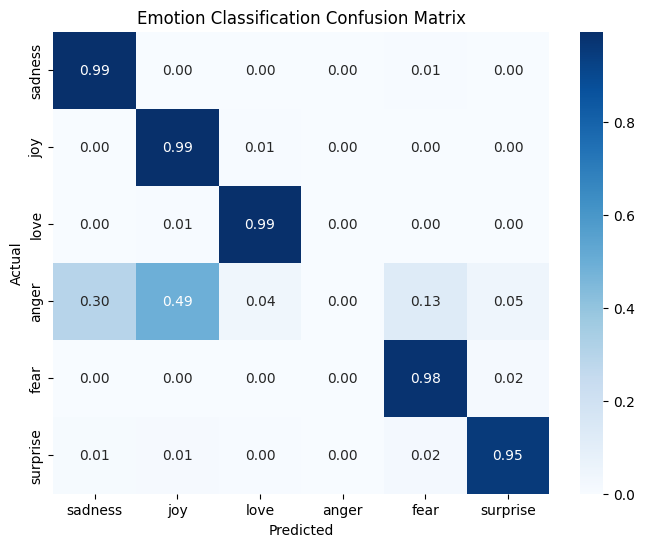

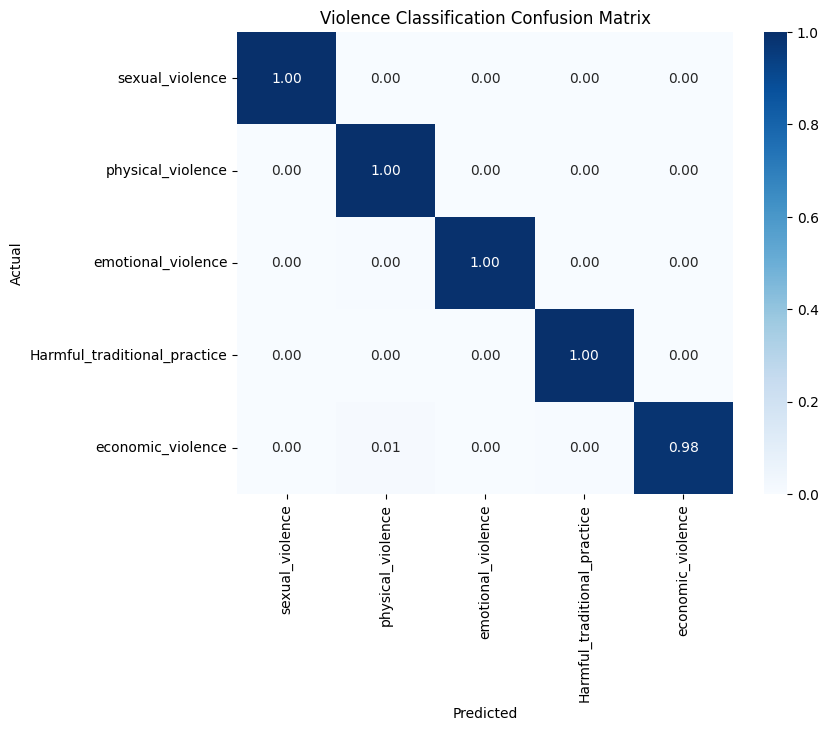

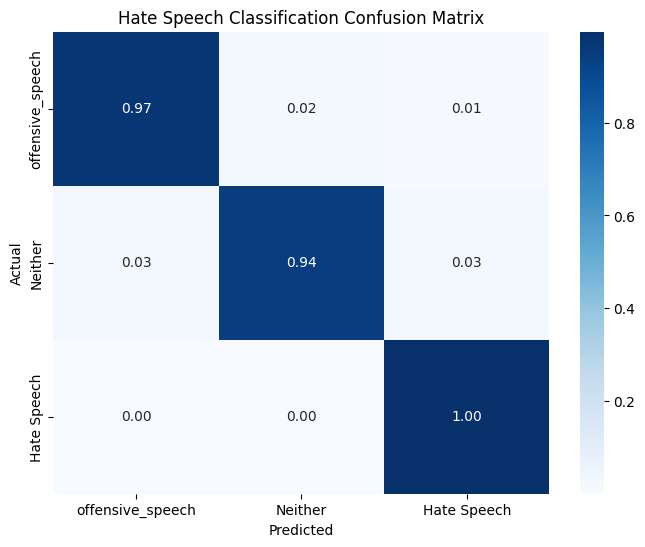

In [154]:
plot_confusion_matrix(emotion_labels, emotion_pred, 'Emotion Classification Confusion Matrix', emotion_labels_list)
plot_confusion_matrix(violence_labels, violence_pred, 'Violence Classification Confusion Matrix', violence_labels_list)
plot_confusion_matrix(hate_labels, hate_pred, 'Hate Speech Classification Confusion Matrix', hate_labels_list)

## MANUAL INFERENCE

In [156]:
def classify_text(input_text):
    # Preprocess the input text
    input_text_cleaned = remove_stopwords(input_text)
    input_sequence = tokenizer.texts_to_sequences([input_text_cleaned])
    input_padded = pad_sequences(input_sequence, maxlen=max_length, padding='post')

    # Predict using the model
    prediction = model.predict({
        'emotion_input': input_padded,
        'violence_input': input_padded,
        'hate_input': input_padded
    })
    emotion_pred = np.argmax(prediction[0], axis=1)[0]
    violence_pred = np.argmax(prediction[1], axis=1)[0]
    hate_pred = np.argmax(prediction[2], axis=1)[0]

    # determine major labels(emotion, violence, hate) based on prediction index
    major_labels = ['Emotion', 'Violence', 'Hate Speech']
    major_label_index = np.argmax([np.max(prediction[0]), np.max(prediction[1]), np.max(prediction[2])])
    major_label = major_labels[major_label_index]

    #Determining sublabels
    emotion_labels_text = ['sadness', 'joy', 'love', 'anger', 'fear' ,'surprise']
    violence_labels_text = ['sexual_violence', 'physical_violence', 'emotional_violence', 'Harmful_traditional_practice', 'economic_violence']
    hate_labels_text = ['offensive_speech', 'Neither', 'Hate Speech']

    if major_label == 'Emotion':
        sublabel = emotion_labels_text[emotion_pred]
    elif major_label == 'Violence':
        sublabel = violence_labels_text[violence_pred]
    else:
        sublabel = hate_labels_text[hate_pred]  

    return major_label, sublabel  


In [158]:
#NEXT IS UI TO SHOW THIS WORKFLOW 

#WE WILL DO IT USING STREAMLIT
# FIRSTLY SPLIT FILE INTO MULTIPLE .py files based on utility, and connect them together
# Then create a streamlit app(app.py) to take user input and display the results